In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import pickle
import matplotlib.pyplot as plt
from glob import glob
import sys
import pandas as pd

In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters
from neurosim.models.var import form_companion

In [4]:
from sklearn.decomposition import PCA
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [5]:
from scipy.stats import ortho_group

In [108]:
# Load the polar decomposition parameterization of A matrices and plot
# (1) the increase of non-normality
# (2) Example plots of the polar decompositions
# (3) Sabes polar decomposition 
# (4) Examples of the pseudospectra

In [7]:
dim = 100
nU = 1
nP = 50
seed = 1
# 50 random U matrices. Then modulate the spread of the diagonals of P for each U

U = []
for i in range(nU):
    U.append(ortho_group.rvs(dim, random_state=seed))


In [8]:
# Just re-generate them here:
Puniform = []
delta = []
for j in range(nP):
    Puniform.append(np.diag(np.linspace(0.8 - j/nP * 0.6, 0.8 + j/nP * 0.6, dim)))
    delta.append(0.8 + j/nP * 0.6 - (0.8 - j/nP * 0.6))

Pclustered = []
for j in range(50):

    # Smaller cluster
    smaller_cluster = np.linspace(0.8 - j/nP * 0.6, 0.8 - j/nP * 0.2, dim//2)
    larger_cluster = np.linspace(0.8 + j/nP * 0.2, 0.8 + j/nP * 0.6, dim//2)
    sigma = np.append(smaller_cluster, larger_cluster)

    # Larger cluster
    Pclustered.append(np.diag(sigma))

# Check to make sure all eigenvalues have real part < 1
A1 = []
A2 = []

lambda_max = np.zeros((nU, nP, 2))
for i in range(len(U)):
    for j in range(len(Puniform)):

        A_ = U[i] @ Puniform[j]
        lambda_max[i, j, 0] = np.max(np.real(np.linalg.eigvals(A_)))     
        A1.append(A_)

        A_ = U[i] @ Pclustered[j]
        lambda_max[i, j, 1] = np.max(np.real(np.linalg.eigvals(A_)))
        A2.append(A_)     

In [111]:
# Load the sabes VAR fits to get the corresponding singular values
# Consolidate
indy_fits = glob('/mnt/Secondary/data/indy_cv_var/indy_cv_var_*.dat')
rl = []
for file_ in indy_fits:
    with open(file_, 'rb') as f:
        args = pickle.load(f)
        coef = pickle.load(f)
    rd = {}
    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in value.items():
                rd[key_] = value_
        else:
            rd[key] = value
    
    rd['coef'] = coef
    rl.append(rd)
indy_df = pd.DataFrame(rl)

In [112]:
data_files = np.unique(indy_df['data_file'].values)

In [113]:
df_ = apply_df_filters(indy_df, data_file=data_files[0], fold_idx = 2, order=3)
A_M1 = form_companion(df_.iloc[0]['coef'])

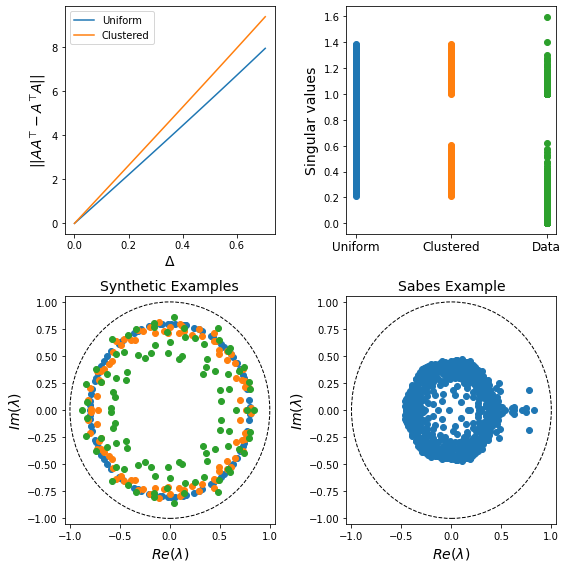

In [131]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

nn = np.zeros((len(Puniform), 2))
for i in range(len(Puniform)):
    nn[i, 0] = np.linalg.norm(A1[i] @ A1[i].T - A1[i].T @ A1[i])
    nn[i, 1] = np.linalg.norm(A2[i] @ A2[i].T - A2[i].T @ A2[i])
ax[0, 0].plot(np.array(delta) * 0.6, nn[:, 0])
ax[0, 0].plot(np.array(delta) * 0.6, nn[:, 1])
ax[0, 0].legend(['Uniform', 'Clustered'])
ax[0, 0].set_ylabel(r'$||AA^\top - A^\top A||$', fontsize=14)
ax[0, 0].set_xlabel(r'$\Delta$', fontsize=14)

_, s1, _ = np.linalg.svd(A1[-1])
_, s2, _ = np.linalg.svd(A2[-1])
_, s3, _ = np.linalg.svd(A_M1)

ax[0, 1].scatter(np.zeros(s1.size), s1)
ax[0, 1].scatter(np.ones(s1.size), s2)
ax[0, 1].scatter(2 * np.ones(s3.size), s3)

ax[0, 1].set_xticks([0, 1, 2])
ax[0, 1].set_xticklabels(['Uniform', 'Clustered', 'Data'], fontsize=12)
ax[0, 1].set_ylabel('Singular values', fontsize=14)

circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax[1, 0].add_patch(circle1)

circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax[1, 1].add_patch(circle1)

# Plot the spectra of a few examples from Pclustered
eig1 = np.linalg.eigvals(A2[0])
eig2 = np.linalg.eigvals(A2[25])
eig3 = np.linalg.eigvals(A2[-1])
ax[1, 0].scatter(np.real(eig1), np.imag(eig1))
ax[1, 0].scatter(np.real(eig2), np.imag(eig2))
ax[1, 0].scatter(np.real(eig3), np.imag(eig3))
ax[1, 0].set_xlim([-1.05, 1.05])
ax[1, 0].set_ylim([-1.05, 1.05])
ax[1, 0].set_ylabel(r'$Im(\lambda)$', fontsize=14)
ax[1, 0].set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax[1, 0].set_title('Synthetic Examples', fontsize=14)

eig = np.linalg.eigvals(A_M1)
ax[1, 1].scatter(np.real(eig), np.imag(eig))
ax[1, 1].set_xlim([-1.05, 1.05])
ax[1, 1].set_ylim([-1.05, 1.05])
ax[1, 1].set_ylabel(r'$Im(\lambda)$', fontsize=14)
ax[1, 1].set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax[1, 1].set_title('Sabes Example', fontsize=14)

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/polar_example.pdf', bbox_inches='tight', pad_inches=0)

In [124]:
U = ortho_group.rvs(2)
P = np.diag([0.99, 0.99])
A = U @ P

In [125]:
P2 = np.diag([0.75, 1.25])
A2 = U @ P2
P3 = np.diag([0.5, 1.5])
A3 = U @ P3

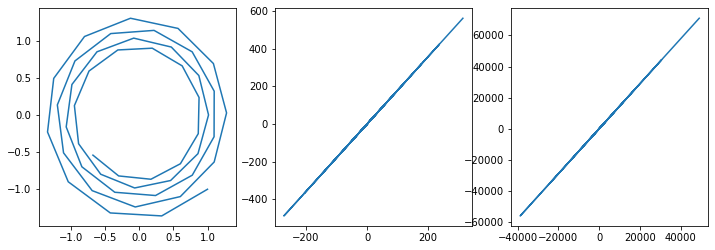

In [126]:
# Plot what happens in a 2D case when the P becomes heterogenous
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

x1 = np.array([np.linalg.matrix_power(A, k) @ np.array([1, -1]) for k in range(50)])
x2 = np.array([np.linalg.matrix_power(A2, k) @ np.array([1, -1]) for k in range(50)])
x3 = np.array([np.linalg.matrix_power(A3, k) @ np.array([1, -1]) for k in range(50)])

ax[0].plot(x[:, 0], x[:, 1])
ax[1].plot(x2[:, 0], x2[:, 1])
ax[2].plot(x3[:, 0], x3[:, 1])

fig.savefig('/home/akumar/nse/neural_control/figs/synth/polar_2D_example.pdf', bbox_inches='tight', pad_inches=0)

In [1]:
# Mock plot of the subspace angle diversion with non-normality

In [7]:
import sys
sys.path.append('/home/akumar/nse/neural_control')

In [8]:
from utils import calc_loadings

In [9]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from tqdm import tqdm
import torch
import pdb

In [9]:
directedness = np.linspace(0, 1, 20)[::-1]
reps = 100
nn = np.zeros((directedness.size, reps))
dt = 1
spearmanr = np.zeros((directedness.size, reps, 2))
phi = np.zeros((directedness.size, reps, 2))

size = 100
d=2

A_examples = []

for ii, d_ in tqdm(enumerate(directedness)):
    for jj in range(reps):
        A = np.zeros((size, size))
        for i in range(A.shape[0]):
            for j in range(i + 1):
                a = 1/(2 * np.sqrt(size)) * np.random.normal(0, 1)
                if i != j:
                    p = scipy.stats.bernoulli.rvs(0.5)
                    if p:
                        A[i, j] = a
                        A[j, i] = d_ * A[i, j]
                    else:
                        A[j, i] = a
                        A[i, j] = d_ * A[j, i]
                        

        np.fill_diagonal(A, -1 *(1e-2 + np.max(np.real(np.linalg.eigvals(A)))))

# #        while max(np.real(np.linalg.eigvals(A))) > 0:
#         while max(np.real(np.linalg.eigvals(A))) > 0:
#             # print('Unstable, trying again')
#             A = np.zeros((size, size))
#             for i in range(A.shape[0]):
#                 for j in range(i + 1):
#                     a = 1/(2 * np.sqrt(size)) * np.random.normal(0, 1)
#                     if i != j:
#                         p = scipy.stats.bernoulli.rvs(0.5)
#                         if p:
#                             A[i, j] = a
#                             A[j, i] = d_ * A[i, j]
#                         else:
#                             A[j, i] = a
#                             A[i, j] = d_ * A[j, i]

#                     else:
#                         A[i, i] = -1
        nn[ii, jj] = np.linalg.norm(A @ A.T - A.T @ A)
        if jj == 0:
            A_examples.append(A)

        # Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
        # t_ = [j * dt for j in range(10)]
        # cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

        # d = 6
        # # ssr = SSR(A=Ad, B=Bd, C=Cd)
        # # cross_covs = ssr.autocorrelation(10)
        # cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]
        # cross_covs = torch.tensor(cross_covs)
        # cross_covs_rev = torch.tensor(cross_covs_rev)

        # # ssr = SSR(A=A, B = np.eye(A.shape[0]), C=np.eye(A.shape[0]))

        # # cross_covs = ssr.autocorrelation(10)
        # # cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

        # # cross_covs = torch.tensor(cross_covs)
        # # cross_covs_rev = torch.tensor(cross_covs_rev)
        
        # e, Upca = np.linalg.eig(cross_covs[0])
        # eigorder = np.argsort(e)[::-1]
        # Upca = Upca[:, eigorder][:, 0:d]

        # lqgmodel = LQGCA(d=6, T=1)
        # lqgmodel.cross_covs = cross_covs
        # lqgmodel.cross_covs_rev = cross_covs_rev

        # Ulqg, _ = lqgmodel._fit_projection()

        # phi[ii, jj, 0] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        # spearmanr[ii, jj, 0] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]

        # lqgmodel = LQGCA(d=2, T=1)
        # lqgmodel.cross_covs = cross_covs
        # lqgmodel.cross_covs_rev = cross_covs_rev

        # Ulqg, _ = lqgmodel._fit_projection()
        # phi[ii, jj, 1] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        # spearmanr[ii, jj, 1] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]


20it [03:42, 11.12s/it]


In [22]:
phi.shape

(20, 1, 2)

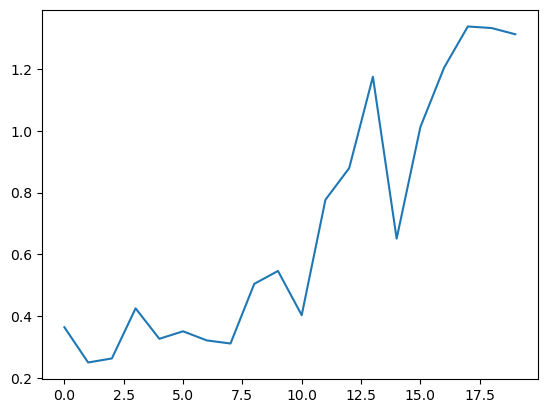

In [23]:
plt.plot(phi[:, 0, 0])

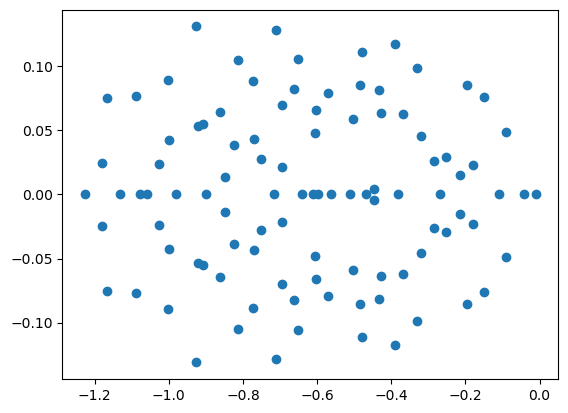

In [16]:
plt.scatter(np.real(np.linalg.eigvals(A_examples[12])), np.imag(np.linalg.eigvals(A_examples[12])))

In [50]:
phi.shape

(20, 100, 2)

In [9]:
# with open('synth_run_continuous.pkl', 'wb') as f:
#     f.write(pickle.dumps(phi))
#     f.write(pickle.dumps(spearmanr))
#     f.write(pickle.dumps(nn))
with open('synth_run_continuous.pkl', 'rb') as f:
    phi = pickle.load(f)
    spearmanr = pickle.load(f)
    nn = pickle.load(f)


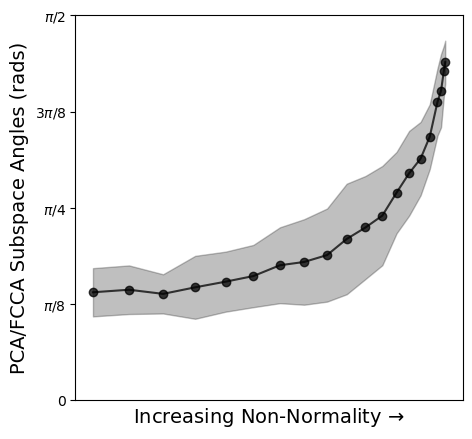

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.mean(nn, axis=1), np.mean(phi[..., 1], axis=1), color='k', alpha=0.75, marker='o')
ax.fill_between(np.mean(nn, axis=1), np.mean(phi[..., 1], axis=1) - np.std(phi[..., 1], axis=1), np.mean(phi[..., 1], axis=1) + np.std(phi[..., 1], axis=1), color='k', alpha=0.25)
#plt.plot(np.mean(phi[..., 1], axis=1))
ax.set_xlabel('Increasing Non-Normality ' + r'$\to$', fontsize=14)
ax.set_ylabel('PCA/FCCA Subspace Angles (rads)', fontsize=14)
ax.set_xticks([])
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/synth/synth_example_cont.pdf', bbox_inches='tight', pad_inches=0)
#plt.legend(['FCCA new', 'FCCA old'], fontsize=12)

In [23]:
from pseudopy.nonnormal import NonnormalAuto
from pseudopy.normal import Normal

In [33]:
nn1 = NonnormalAuto(A_examples[0], 1e-5, 1)
nn2 = NonnormalAuto(A_examples[12], 1e-5, 1)
nn3 = NonnormalAuto(A_examples[19], 1e-5, 1)

In [34]:
n1 = Normal(A_examples[0])
n2 = Normal(A_examples[12])
n3 = Normal(A_examples[19])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


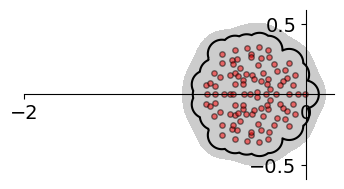

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))
nnobj = nn3
nobj = n3
A_ = A_examples[19]

levels = [1e-6, 1e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)

ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-1, 0.2])
ax.set_ylim([-0.6, 0.6])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-2, 0])
ax.set_yticks([-0.5, 0.5])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/synth3.pdf', bbox_inches='tight', pad_inches=0)

In [84]:
np.max(np.linalg.eigvals(A_examples[0] - np.eye(A.shape[0])))

-0.029816497341111407

In [ ]:
nn1 = NonnormalAuto(A_examples, 1e-5, 1)

[]

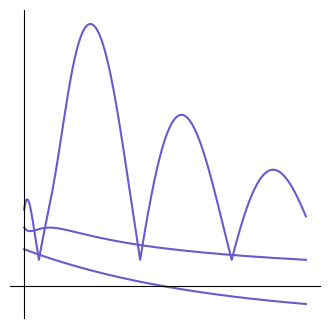

In [11]:
# Plot trajectories along the leading eigenvector of the controllability Grammian
# 0, 12, 19
fig, ax = plt.subplots(figsize=(4, 4))

for i, A in enumerate([A_examples[0], A_examples[12], A_examples[19]]):
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
    eig, U = np.linalg.eig(Pi)
    eigorder = np.argsort(eig)[::-1]
    U = U[:, eigorder]
    U = U[:, 0][:, np.newaxis]

    # Simulate from A with unit vector initial condition
    def f(y, t):
        return A @ y

    y = scipy.integrate.odeint(f, 1/np.sqrt(A.shape[0]) * np.ones(A.shape[0]), np.linspace(0, 150, 10000))
    
    yproj = np.abs(y @ U)
    # Start at the same point
    #yproj -= yproj[0] - 0.1

    # Manually adjust
    if i == 0:
        yproj -= 0.1
    if i == 1:
        yproj += 0.05
    if i == 2:
        yproj += 0.08

    ax.plot(yproj, color='slateblue')

ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
ax.set_xticks([])
ax.set_yticks([])

#fig.savefig('nn_trajectories.pdf', bbox_inches='tight', pad_inches=0)

### Interpolate between M1 spectra and a symmetric version so pseudospectra may better resemble the data

In [6]:
from loaders import load_sabes
from utils import calc_loadings
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import torch

In [11]:
X = dat['spike_rates'].squeeze()
xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)

In [8]:
dat = load_sabes('/mnt/Secondary/data/sabes/indy_20160627_01.mat')

In [12]:
# Question 1: Affect of self regression on the spectrum and predictive capacity

A_smooth = []
r2_smooth = []

A_smooth_diff = []
r2_smooth_diff = []


for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(xsmooth)):
    xtrain = xsmooth[train_idxs]
    xtest = xsmooth[test_idxs]

    xtrain = StandardScaler().fit_transform(xtrain)
    xtest = StandardScaler().fit_transform(xtest)

    linmodel = LinearRegression().fit(xtrain[:-1, :], xtrain[1:, :])
    # print(r2_score(xtest[1:, :], xtest[:-1, :] @ linmodel.coef_))

    A_smooth.append(linmodel.coef_)

    xdiff_train = StandardScaler().fit_transform(np.diff(xtrain, axis=0))
    xdiff_test = StandardScaler().fit_transform(np.diff(xtest, axis=0))

    linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)
    # print(r2_score(xdiff_test, xtest[:-1, :] @ linmodel.coef_))

    A_smooth_diff.append(linmodel.coef_)


5it [00:04,  1.11it/s]


In [25]:
directedness = np.linspace(0, 1, 20)[::-1]
reps = 1
nn = np.zeros((directedness.size, reps))
dt = 1
spearmanr = np.zeros((directedness.size, reps, 2))
phi = np.zeros((directedness.size, reps, 2))

size = 100
d=2

A_examples = []

t = np.linspace(0, 1, 20)
Asym = 0.5 * (A_smooth_diff[0] + A_smooth_diff[0].T)

for ii, d_ in tqdm(enumerate(directedness)):
    for jj in range(reps):
        A = (1 - t[ii]) * Asym + Asym * t[ii]

        # for i in range(A.shape[0]):
        #     for j in range(i + 1):
        #         a = 1/(2 * np.sqrt(size)) * np.random.normal(0, 1)
        #         if i != j:
        #             p = scipy.stats.bernoulli.rvs(0.5)
        #             if p:
        #                 A[i, j] = a
        #                 A[j, i] = d_ * A[i, j]
        #             else:
        #                 A[j, i] = a
        #                 A[i, j] = d_ * A[j, i]
                        

        # np.fill_diagonal(A, -1 *(1e-2 + np.max(np.real(np.linalg.eigvals(A)))))

        epsilon = 1e-2
        while max(np.real(np.linalg.eigvals(A))) > 0:
            print('Unstable, trying again')
            A -= epsilon * np.eye(A.shape[0])
            epsilon += 1e-2

        nn[ii, jj] = np.linalg.norm(A @ A.T - A.T @ A)
        if jj == 0:
            A_examples.append(A)

        Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
        t_ = [j * dt for j in range(10)]
        cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

        d = 6
        # ssr = SSR(A=Ad, B=Bd, C=Cd)
        # cross_covs = ssr.autocorrelation(10)
        cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]
        cross_covs = torch.tensor(cross_covs)
        cross_covs_rev = torch.tensor(cross_covs_rev)

        # ssr = SSR(A=A, B = np.eye(A.shape[0]), C=np.eye(A.shape[0]))

        # cross_covs = ssr.autocorrelation(10)
        # cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

        # cross_covs = torch.tensor(cross_covs)
        # cross_covs_rev = torch.tensor(cross_covs_rev)
        
        e, Upca = np.linalg.eig(cross_covs[0])
        eigorder = np.argsort(e)[::-1]
        Upca = Upca[:, eigorder][:, 0:d]

        lqgmodel = LQGCA(d=6, T=5)
        lqgmodel.cross_covs = cross_covs
        lqgmodel.cross_covs_rev = cross_covs_rev

        Ulqg, _ = lqgmodel._fit_projection()

        phi[ii, jj, 0] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        spearmanr[ii, jj, 0] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]

        lqgmodel = LQGCA(d=2, T=1)
        lqgmodel.cross_covs = cross_covs
        lqgmodel.cross_covs_rev = cross_covs_rev

        Ulqg, _ = lqgmodel._fit_projection()
        phi[ii, jj, 1] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        spearmanr[ii, jj, 1] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]


0it [00:00, ?it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


1it [00:00,  1.94it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


2it [00:00,  2.15it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


3it [00:01,  2.20it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


4it [00:01,  2.30it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


5it [00:02,  2.23it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


6it [00:02,  2.28it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


7it [00:03,  2.40it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


8it [00:03,  2.48it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


9it [00:03,  2.52it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


10it [00:04,  2.69it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


11it [00:04,  2.74it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


12it [00:04,  2.78it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


13it [00:05,  2.75it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


14it [00:05,  2.72it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


15it [00:05,  2.80it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


16it [00:06,  2.75it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


17it [00:06,  2.45it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


18it [00:07,  2.62it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


19it [00:07,  2.70it/s]

Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again
Unstable, trying again


20it [00:07,  2.56it/s]


In [ ]:
# Given the results, could use the eigenvalues as a guide and increase the degree to which the matrix is ill-conditioned relative to the
# neural data.

In [ ]:
# Rotate eigenvalues from real to imaginary

In [9]:
np.linalg.eigvals(np.array([[1, 2], [-2, 1]]))

array([1.+2.j, 1.-2.j])

In [8]:
def rotate_vector(vec, theta):
    """
    Rotates a 2-element vector by an angle theta.
    
    Args:
    vec (numpy.ndarray): A 2-element vector.
    theta (float): The angle of rotation in radians.
    
    Returns:
    numpy.ndarray: The rotated vector.
    """
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    return rotation_matrix @ vec

In [9]:
def construct_block_diag_matrix(eigenvalues):
    """
    Constructs a block diagonal matrix with 2x2 blocks that yield desired real eigenvalues.
    
    Args:
    eigenvalues (list): A list of real eigenvalues.
    
    Returns:
    numpy.ndarray: The block diagonal matrix.
    """
    n_blocks = len(eigenvalues)
    block_diag_matrix = np.zeros((2*n_blocks, 2*n_blocks), dtype=np.float64)
    for ii in range(n_blocks):
        block_diag_matrix[2*ii:2*ii+2, 2*ii:2*ii+2] = np.array([[np.real(eigenvalues[ii]), np.imag(eigenvalues[ii])],
                                                                [-np.imag(eigenvalues[ii]), np.real(eigenvalues[ii])]])
    return block_diag_matrix

In [10]:
def basis_condition_number(cond_num, n):
    """
    Returns a full rank matrix with a specified condition number.
    
    Args:
    cond_num (float): The desired condition number.
    n (int): The dimension of the matrix.
    
    Returns:
    numpy.ndarray: The full rank matrix.
    """
    # Generate a random matrix with orthogonal columns
    Q, _ = np.linalg.qr(np.random.randn(n, n))
    
    # Generate a diagonal matrix with the desired singular values
    singular_values = np.linspace(cond_num, 1, n)
    D = np.diag(singular_values)
    
    # Construct the full rank matrix
    A = Q @ D @ Q.T
    
    return A

In [11]:
# Angle from the real axis
#theta = np.linspace(0, np.pi/2 + np.pi/6, 20)
theta = np.linspace(0, 1, 20)
condition_numbers = np.linspace(1, 25, theta.size)
reps = 100
nn = np.zeros((theta.size, reps))
dt = 1
spearmanr = np.zeros((theta.size, reps, 2))
phi = np.zeros((theta.size, reps, 2))

size = 50
d=2

A_examples = []

seed = 135
rand = np.random.RandomState(seed)

t = np.linspace(0, 1, 20)
for ii, th_ in tqdm(enumerate(theta)):
    for jj in range(reps):
        cond_number = condition_numbers[ii]
        # Draw eigenvalue distribution from -0.1 to -1
        if ii == 0:
            lamb_ = np.linspace(-1, -0.1, size)
            D = np.diag(lamb_)
            S = basis_condition_number(cond_number, size)
        else:
            # Progressively shrink the real part and expand the imaginary part
            lamb_re = rand.uniform(-2 + 1.5 * th_, -0.1, size//2)
            lamba_im = rand.uniform(0, 0.6 * th_, size//2)
            # Rotate the vector
            # lamb_ = [np.array([l, 0]) for l in lamb_]
            # lamb_ = [rotate_vector(l, th_) for l in lamb_]
            # lamb_ = [l[0] + 1j * l[1] for l in lamb_]
            lamb_ = [l1 + 1j * l2 for l1, l2 in zip(lamb_re, lamba_im)]
            # Constrtuct a block diagonal matrix
            D = construct_block_diag_matrix(lamb_)
            # Construct a full rank matrix with the desired condition number
            S = basis_condition_number(cond_number, size)

        A = S @ D @ np.linalg.inv(S)

        epsilon = 1e-2
        while max(np.real(np.linalg.eigvals(A))) > 0:
            print('Unstable, trying again')
            A -= epsilon * np.eye(A.shape[0])
            
            epsilon += 1e-2

        nn[ii, jj] = np.linalg.norm(A @ A.T - A.T @ A)
        if jj == 0:
            A_examples.append(A)

        Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
        t_ = [j * dt for j in range(10)]
        cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

        d = 6
        # ssr = SSR(A=Ad, B=Bd, C=Cd)
        # cross_covs = ssr.autocorrelation(10)
        cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]
        cross_covs = torch.tensor(cross_covs)
        cross_covs_rev = torch.tensor(cross_covs_rev)

        # ssr = SSR(A=A, B = np.eye(A.shape[0]), C=np.eye(A.shape[0]))

        # cross_covs = ssr.autocorrelation(10)
        # cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

        # cross_covs = torch.tensor(cross_covs)
        # cross_covs_rev = torch.tensor(cross_covs_rev)
        
        e, Upca = np.linalg.eig(cross_covs[0])
        eigorder = np.argsort(e)[::-1]
        Upca = Upca[:, eigorder][:, 0:d]

        lqgmodel = LQGCA(d=6, T=5)
        lqgmodel.cross_covs = cross_covs
        lqgmodel.cross_covs_rev = cross_covs_rev

        Ulqg, _ = lqgmodel._fit_projection()

        phi[ii, jj, 0] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        spearmanr[ii, jj, 0] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]

        lqgmodel = LQGCA(d=2, T=1)
        lqgmodel.cross_covs = cross_covs
        lqgmodel.cross_covs_rev = cross_covs_rev

        Ulqg, _ = lqgmodel._fit_projection()
        phi[ii, jj, 1] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        spearmanr[ii, jj, 1] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]


0it [00:00, ?it/s]

/tmp/ipykernel_26688/1469833076.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)
20it [12:12, 36.64s/it]


In [6]:
# with open('synth_eig_rotation.pkl', 'wb') as f:
#     f.write(pickle.dumps(phi))
#     f.write(pickle.dumps(spearmanr))
#     f.write(pickle.dumps(nn))
#     f.write(pickle.dumps(A_examples))
with open('synth_eig_rotation.pkl', 'rb') as f:
    phi = pickle.load(f)
    spearmanr = pickle.load(f)
    nn = pickle.load(f)
    A_examples = pickle.load(f)


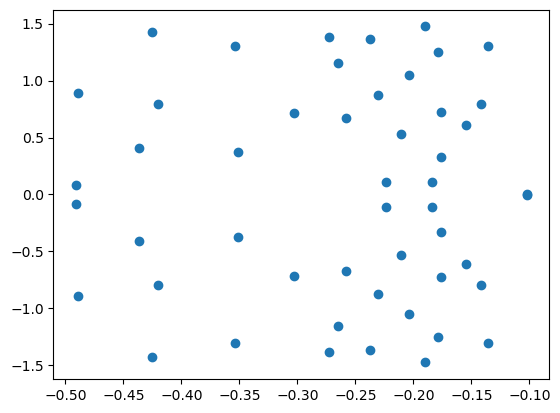

In [36]:
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))

In [37]:
phi

array([[[0.28720892, 0.07874847]],

       [[0.14647687, 0.09367156]],

       [[0.90257401, 0.53392618]],

       [[0.60266503, 0.56335658]],

       [[0.86131638, 0.76705943]],

       [[0.94184755, 0.90089925]],

       [[1.11696475, 0.9168556 ]],

       [[0.81884473, 0.8838357 ]],

       [[0.98188179, 0.91139963]],

       [[1.15059761, 1.10519198]],

       [[1.18368691, 1.074222  ]],

       [[1.17948472, 1.0033438 ]],

       [[1.25738534, 0.99123399]],

       [[1.16716727, 0.98095436]],

       [[1.38329037, 0.77966577]],

       [[1.42817871, 1.16096011]],

       [[1.27389432, 0.84120367]],

       [[1.36976484, 0.89963629]],

       [[1.32244735, 0.9471847 ]],

       [[1.43304332, 0.76887371]]])

In [58]:
nn.shape

(20, 100)

In [59]:
phi.shape

(20, 100, 2)

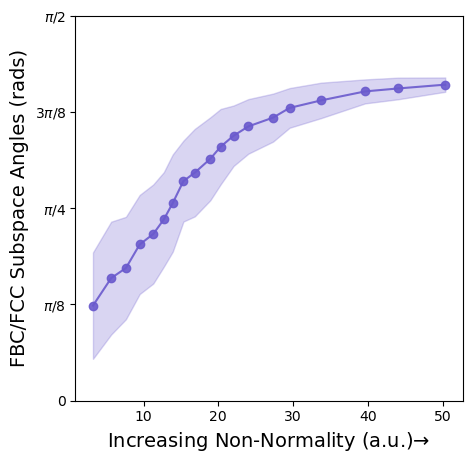

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.mean(nn[1:], axis=1), np.mean(phi[1:][..., 0], axis=1), color='slateblue', alpha=0.9, marker='o')
ax.fill_between(np.mean(nn[1:], axis=1), np.mean(phi[1:][..., 0], axis=1) - np.std(phi[1:][..., 0], axis=1), np.mean(phi[1:][..., 0], axis=1) + np.std(phi[1:][..., 0], axis=1), color='slateblue', alpha=0.25)
#plt.plot(np.mean(phi[..., 1], axis=1))
ax.set_xlabel('Increasing Non-Normality (a.u.)' + r'$\to$', fontsize=14)
ax.set_ylabel('FBC/FCC Subspace Angles (rads)', fontsize=14)
#ax.set_xticks([])
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/synth/synth_example_cont.pdf', bbox_inches='tight', pad_inches=0)
#plt.legend(['FCCA new', 'FCCA old'], fontsize=12)

In [1]:
# Plot spectra

In [7]:
from pseudopy import NonnormalAuto, Normal

In [8]:
nn1 = NonnormalAuto(A_examples[0], 1e-5, 1)
nn2 = NonnormalAuto(A_examples[10], 1e-5, 1)
nn3 = NonnormalAuto(A_examples[19], 1e-5, 1)

In [9]:
n1 = Normal(A_examples[0])
n2 = Normal(A_examples[10])
n3 = Normal(A_examples[19])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


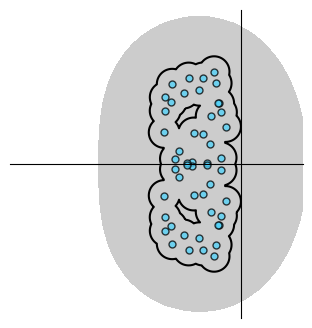

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
nnobj = nn3
nobj = n3
A_ = A_examples[19]

levels = [1e-6, 1e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)

ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=25, alpha=0.75, marker='o', edgecolor='k', color='#4dd2fa')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-1.5, 0.4])
ax.set_ylim([-1.0, 1.0])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/synth3.pdf', bbox_inches='tight', pad_inches=0)

In [26]:
y.shape

(10000, 50)

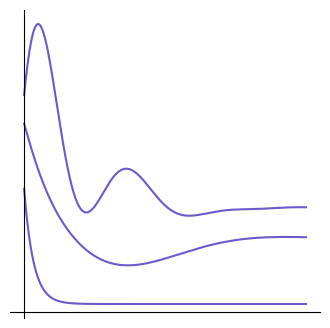

In [63]:
# Plot trajectories along the leading eigenvector of the controllability Grammian
# 0, 12, 19
fig, ax = plt.subplots(figsize=(4, 4))

for i, A in enumerate([A_examples[0], A_examples[10], A_examples[19]]):
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
    eig, U = np.linalg.eig(Pi)
    eigorder = np.argsort(eig)[::-1]
    U = U[:, eigorder]
    U = U[:, 0][:, np.newaxis]

    # Simulate from A with unit vector initial condition
    def f(y, t):
        return A @ y

    y = scipy.integrate.odeint(f, 1/np.sqrt(A.shape[0]) * np.ones(A.shape[0]), np.linspace(0, 150, 10000))
    
    #yproj = np.abs(y @ U)
    # Start at the same point
    #yproj -= yproj[0] - 0.1

    # Manually adjust
    if i == 0:
        pass
        yproj = y[:2000, 0]
        yproj -= 0.04
    if i == 1:
        yproj = y[:2000, 14]
        yproj += 0.04
    if i == 2:
        yproj = y[:2000, 0]
        yproj += 0.075

    ax.plot(yproj, color='slateblue')

ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position(('data', -0.05))

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
ax.set_xticks([])
ax.set_yticks([])

fig.savefig('nn_trajectories.pdf', bbox_inches='tight', pad_inches=0)